#### Answer book for Bayesian Inference Project

The goal is to construct a model for individual charges that lets us predict the financial outputs we can expect in times of low patient influx.

We will do this for non-insured charges using Bayesian Inference.

In [1]:
# Exploration of the data set

import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt

medical = pd.read_csv('insurance2.csv')
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


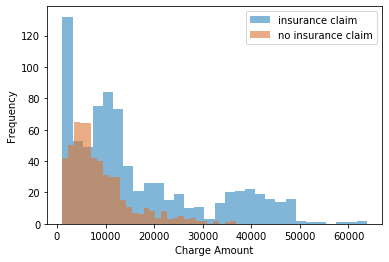

In [2]:
insurance = medical.charges[medical.insuranceclaim == 1]
no_insurance = medical.charges[medical.insuranceclaim == 0]

_ = plt.hist(insurance, bins=30, alpha=0.6, color="#2E86C1", label='insurance claim')
_ = plt.hist(no_insurance, bins=30, alpha=0.6, color="#DC7633", label='no insurance claim')
_ = plt.xlabel('Charge Amount')
_ = plt.ylabel('Frequency')
_ = plt.legend(loc='upper right')
plt.show()


Comparison of the no insurance claim charges to a gamma distribution

In [3]:
from scipy.stats import gamma
np.random.seed(47)

#Parameter estimation
alpha_est = np.mean(no_insurance)**2/np.var(no_insurance)
beta_est = np.var(no_insurance)/np.mean(no_insurance)

n_ins = len(insurance)
n_no_ins = len(no_insurance)

no_ins_model_rvs = gamma(alpha_est, scale=beta_est).rvs(n_no_ins)


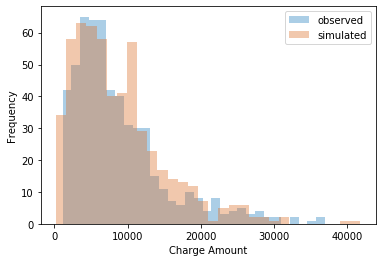

In [4]:
_ = plt.hist(no_insurance, bins=30, color="#2E86C1", alpha=0.4, label='observed')
_ = plt.hist(no_ins_model_rvs, bins=30, color="#DC7633", alpha=0.4, label='simulated')
_ = plt.xlabel('Charge Amount')
_ = plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


The comparison looks close but the question remains of fine-tuning the parameters. Also, the uncertainty of the params was not captured above.
We will fine-tune the alpha and beta params using Bayesian inference using the starting points as calculated from the sample data set.
Alpha and Beta will be modelled as exponential functions that will then be fed into a simulated distribution (gamma distribution) constrained by the observed sample data set.

Initial Parameter Estimation:

In [6]:
# PyMC3 uses rate = 1/beta
rate_est = 1/beta_est
# Initial parameter estimates we'll use below
alpha_est, rate_est

(1.8759059725250857, 0.00021265346963636093)

Building the Model:

In [7]:
with pm.Model() as model:
    alpha_ = pm.Exponential("alpha", lam=1/alpha_est)
    beta_ = pm.Exponential("beta", lam=1/rate_est)
    
    observations = pm.Gamma("obs", alpha=alpha_, beta=beta_, observed=no_insurance)

Solving the Model for the defined stochastic variables:

In [8]:
with model:
    start = pm.find_MAP()
    step = pm.Metropolis(vars=[alpha_, beta_, observations])
    trace = pm.sample(10000, step=step, start=start)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 19 seconds.
The number of effective samples is smaller than 10% for some parameters.


Drawing Traces:

In [9]:
#Drawing traces

alpha_trace = trace['alpha']
beta_trace = trace['beta']
CI_alpha = np.percentile(alpha_trace, [2.5, 97.5])
CI_beta = np.percentile(beta_trace, [2.5, 97.5])

Visualizing the traces and their spread:

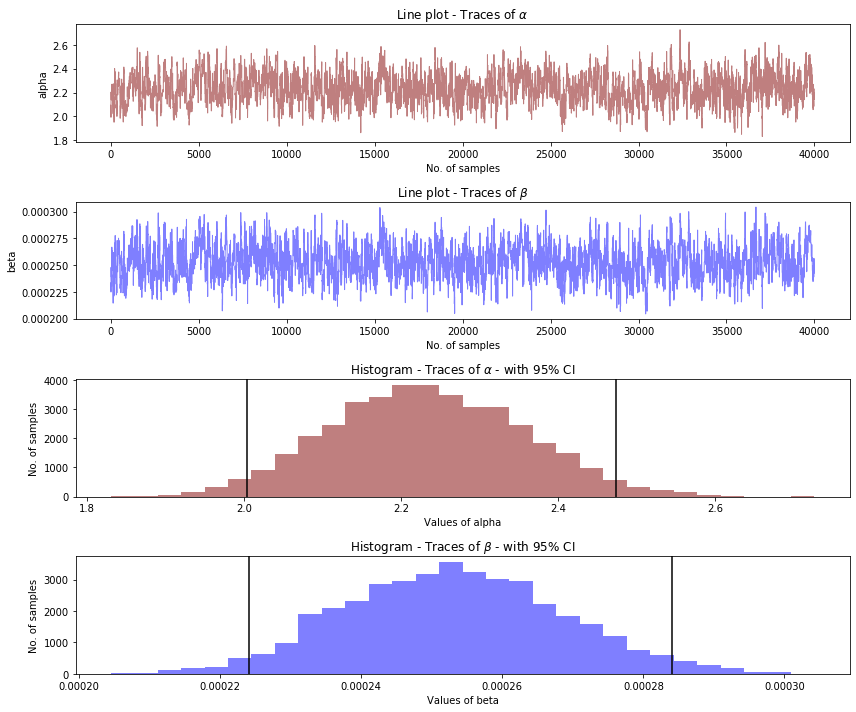

In [11]:
# Visualizing the traces and their spread

from IPython.core.pylabtools import figsize

figsize(12,10)
plt.subplot(411)
plt.plot(alpha_trace, color='maroon', alpha=0.5, linewidth=1)
plt.title(r"Line plot - Traces of $\alpha$")
plt.xlabel('No. of samples')
plt.ylabel('alpha')

plt.subplot(412)
plt.plot(beta_trace, color='blue', alpha=0.5, linewidth=1)
plt.title(r"Line plot - Traces of $\beta$")
plt.xlabel('No. of samples')
plt.ylabel('beta')

plt.subplot(413)
plt.hist(alpha_trace, bins=30, color='maroon', alpha=0.5)
plt.axvline(CI_alpha[0], linewidth=1.5, color='black')
plt.axvline(CI_alpha[1], linewidth=1.5, color='black')
plt.title(r"Histogram - Traces of $\alpha$ - with 95% CI")
plt.xlabel('Values of alpha')
plt.ylabel('No. of samples')

plt.subplot(414)
plt.hist(beta_trace, bins=30, color='blue', alpha=0.5)
plt.axvline(CI_beta[0], linewidth=1.5, color='black')
plt.axvline(CI_beta[1], linewidth=1.5, color='black')
plt.title(r"Histogram - Traces of $\beta$ - with 95% CI")
plt.xlabel('Values of beta')
plt.ylabel('No. of samples')

plt.tight_layout()
plt.show()

Using pymc3 plot tools for the same:

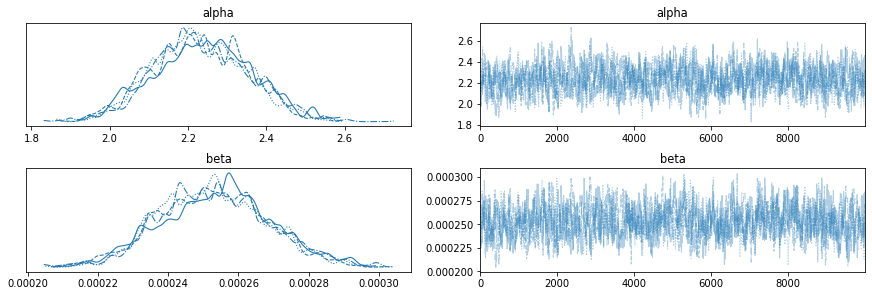

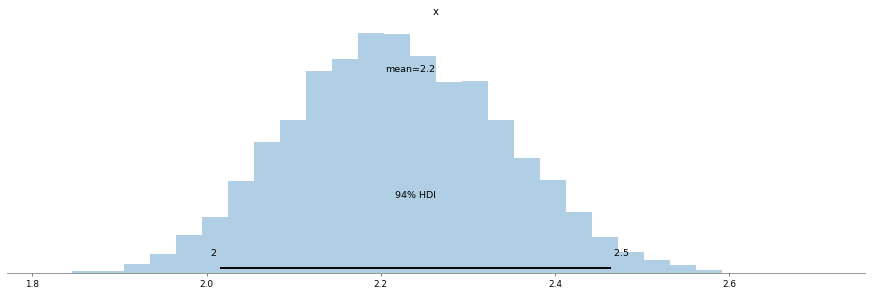

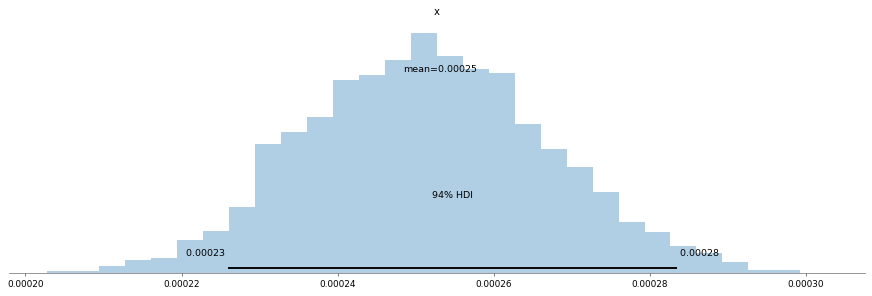

In [13]:
figsize(12,10)
with model:
    pm.plots.traceplot(data=trace, var_names=["alpha", "beta"])
    pm.plots.plot_posterior(data=trace["alpha"], kind='hist', bins=30, figsize=(12,4))
    pm.plots.plot_posterior(data=trace["beta"], kind='hist', bins=30, figsize=(12,4))

Using the new calculated params to compare the simulated gamma distribution with the observed dataset:

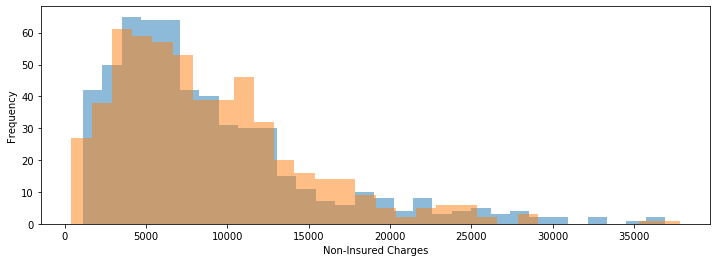

In [15]:
np.random.seed(47)
alpha_sim = np.mean(alpha_trace[10000:])
beta_sim = np.mean(beta_trace[10000:])
best_shot_simulated = gamma(alpha_sim, scale=1/beta_sim).rvs(n_no_ins)
figsize(12,4)
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='observed')
_ = plt.hist(best_shot_simulated, bins=30, alpha=0.5, label='simulated')
_ = plt.xlabel('Non-Insured Charges')
_ = plt.ylabel('Frequency')
plt.show()